<a href="https://colab.research.google.com/github/DiploDatos/AnalisisYCuracion/blob/master/Entregable_Parte_2_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones**

**Exploración y Curación de Datos**

*Edición 2021*

----

# Trabajo práctico entregable - parte 2


En el ejercicio 2 de la parte 1 del entregable seleccionaron las filas y columnas relevantes al problema de predicción de precios de una propiedad e imputaron los valores faltantes de las columnas `Suburb` y las columnas obtenidas a partir del conjunto de datos `airbnb`.

En esta notebook, **se utilizará resultado de dichas operaciones.** que fue guardado en un archivo (Ejercicio 3 entregable 1). 


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

from sklearn.experimental import enable_iterative_imputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import IterativeImputer
import seaborn as sns

sns.set_context('talk')

In [2]:
# Acá deberían leer el conjunto de datos que ya tienen.
melb_df = pd.read_csv('melb_df_merged.csv')
melb_df[:3]

,Suburb,Rooms,Type,Price,Method,Distance,Postcode,Bathroom,Car,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,zipcode,airbnb_price_mean,airbnb_price_count
0,Abbotsford,2,h,1480000.0,S,2.5,3067.0,1.0,1.0,NaN,NaN,Yarra,-37.7996,144.9984,Northern Metropolitan,3067.0,140.292994,157.0
1,Abbotsford,2,h,1480000.0,S,2.5,3067.0,1.0,1.0,NaN,NaN,Yarra,-37.7996,144.9984,Northern Metropolitan,3067.0,115.594059,101.0
2,Abbotsford,2,h,1035000.0,S,2.5,3067.0,1.0,0.0,79.0,1900.0,Yarra,-37.8079,144.9934,Northern Metropolitan,3067.0,140.292994,157.0


## Ejercicio 1: Encoding

1. Seleccionar todas las filas y columnas del conjunto de datos obtenido en la parte 1 del entregable, **excepto** `BuildingArea` y `YearBuilt`, que volveremos a imputar más adelante.

2. Aplicar una codificación One-hot encoding a cada fila, tanto para variables numéricas como categóricas. Si lo consideran necesario, pueden volver a reducir el número de categorías únicas.

Algunas opciones:
  1. Utilizar `OneHotEncoder` junto con el parámetro `categories` para las variables categóricas y luego usar `numpy.hstack` para concatenar el resultado con las variables numéricas. 
  2. `DictVectorizer` con algunos pasos de pre-proceso previo.

Recordar también que el atributo `pandas.DataFrame.values` permite acceder a la matriz de numpy subyacente a un DataFrame.


In [3]:
melb_df.columns

Index(['Suburb', 'Rooms', 'Type', 'Price', 'Method', 'Distance', 'Postcode',
       'Bathroom', 'Car', 'BuildingArea', 'YearBuilt', 'CouncilArea',
       'Lattitude', 'Longtitude', 'Regionname', 'zipcode', 'airbnb_price_mean',
       'airbnb_price_count'],
      dtype='object')

Quitamos algunas columnas que no nos aportan valor, como "zipcode" (ya que al hacer merge anteriormente, sabemos que tiene los mismos valores que Postcode), "Lattitude" y "Longitude".

In [4]:
melb_aux = melb_df.copy()
filter_columns = ['Suburb', 'Rooms', 'Type', 'Price', 'Method', 'Distance', 'Postcode',
       'Bathroom', 'Car', 'BuildingArea', 'YearBuilt', 'CouncilArea',
       'Regionname', 'airbnb_price_mean',
       'airbnb_price_count']
melb_aux = melb_aux[filter_columns]
melb_aux.head()

,Suburb,Rooms,Type,Price,Method,Distance,Postcode,Bathroom,Car,BuildingArea,YearBuilt,CouncilArea,Regionname,airbnb_price_mean,airbnb_price_count
0,Abbotsford,2,h,1480000.0,S,2.5,3067.0,1.0,1.0,NaN,NaN,Yarra,Northern Metropolitan,140.292994,157.0
1,Abbotsford,2,h,1480000.0,S,2.5,3067.0,1.0,1.0,NaN,NaN,Yarra,Northern Metropolitan,115.594059,101.0
2,Abbotsford,2,h,1035000.0,S,2.5,3067.0,1.0,0.0,79.0,1900.0,Yarra,Northern Metropolitan,140.292994,157.0
3,Abbotsford,2,h,1035000.0,S,2.5,3067.0,1.0,0.0,79.0,1900.0,Yarra,Northern Metropolitan,115.594059,101.0
4,Abbotsford,3,h,1465000.0,SP,2.5,3067.0,2.0,0.0,150.0,1900.0,Yarra,Northern Metropolitan,140.292994,157.0


In [5]:
melb_aux.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26866 entries, 0 to 26865
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Suburb              26866 non-null  object 
 1   Rooms               26866 non-null  int64  
 2   Type                26866 non-null  object 
 3   Price               26866 non-null  float64
 4   Method              26866 non-null  object 
 5   Distance            26866 non-null  float64
 6   Postcode            26866 non-null  float64
 7   Bathroom            26866 non-null  float64
 8   Car                 26743 non-null  float64
 9   BuildingArea        14118 non-null  float64
 10  YearBuilt           16252 non-null  float64
 11  CouncilArea         24155 non-null  object 
 12  Regionname          26866 non-null  object 
 13  airbnb_price_mean   26847 non-null  float64
 14  airbnb_price_count  26847 non-null  float64
dtypes: float64(9), int64(1), object(5)
memory usage: 3.1+

In [6]:
melb_aux.isna().sum()

Suburb                    0
Rooms                     0
Type                      0
Price                     0
Method                    0
Distance                  0
Postcode                  0
Bathroom                  0
Car                     123
BuildingArea          12748
YearBuilt             10614
CouncilArea            2711
Regionname                0
airbnb_price_mean        19
airbnb_price_count       19
dtype: int64

Como son pocos valores nulos en la columna "Car", los llenamos con 0 suponiendo que no lo completaron porque realmente no tiene cochera ese lugar.

In [7]:
melb_aux['Car'] = melb_aux['Car'].fillna(0)

In [8]:
melb_aux.head()

,Suburb,Rooms,Type,Price,Method,Distance,Postcode,Bathroom,Car,BuildingArea,YearBuilt,CouncilArea,Regionname,airbnb_price_mean,airbnb_price_count
0,Abbotsford,2,h,1480000.0,S,2.5,3067.0,1.0,1.0,NaN,NaN,Yarra,Northern Metropolitan,140.292994,157.0
1,Abbotsford,2,h,1480000.0,S,2.5,3067.0,1.0,1.0,NaN,NaN,Yarra,Northern Metropolitan,115.594059,101.0
2,Abbotsford,2,h,1035000.0,S,2.5,3067.0,1.0,0.0,79.0,1900.0,Yarra,Northern Metropolitan,140.292994,157.0
3,Abbotsford,2,h,1035000.0,S,2.5,3067.0,1.0,0.0,79.0,1900.0,Yarra,Northern Metropolitan,115.594059,101.0
4,Abbotsford,3,h,1465000.0,SP,2.5,3067.0,2.0,0.0,150.0,1900.0,Yarra,Northern Metropolitan,140.292994,157.0


De las columnas categóricas que nos quedan, veremos cuantos valores distintos tiene cada una para ver si conviene hacer alguna reducción de categorías únicas.

In [9]:
for a in melb_aux.select_dtypes(include='object').columns:
    print('En la columna {} hay {} valores distintos.'.format(a, melb_aux[a].nunique()))

En la columna Suburb hay 313 valores distintos.
En la columna Type hay 3 valores distintos.
En la columna Method hay 5 valores distintos.
En la columna CouncilArea hay 33 valores distintos.
En la columna Regionname hay 8 valores distintos.


Vamos a reducir las categorías en las columnas Suburb y CouncilArea, dejando las que tienen una frecuencia mínima de 250 en el caso de la primera y 125 en el caso de la segunda. Las categorías debajo de esos mínimos se agruparon bajo "Other".

In [10]:
#Creamos categoría otros para categorías con frecuencias menores a 250 en la columna Suburb
OtherCat = melb_aux.Suburb.value_counts() [melb_aux.Suburb.value_counts() < 250]
melb_aux['Suburb'] = np.where(melb_aux['Suburb'].isin(OtherCat.index.to_list()), 'Other', melb_aux['Suburb'])

#Creamos categoría otros para categorías con frecuencias menores a 125 en la columna ConcilArea
OtherCat = melb_aux.CouncilArea.value_counts() [melb_aux.CouncilArea.value_counts() < 125]
melb_aux['CouncilArea'] = np.where(melb_aux['CouncilArea'].isin(OtherCat.index.to_list()), 'Other', melb_aux['CouncilArea'])

In [11]:
for a in melb_aux.select_dtypes(include='object').columns:
    print('En la columna {} hay {} valores distintos.'.format(a, melb_aux[a].nunique()))

En la columna Suburb hay 32 valores distintos.
En la columna Type hay 3 valores distintos.
En la columna Method hay 5 valores distintos.
En la columna CouncilArea hay 25 valores distintos.
En la columna Regionname hay 8 valores distintos.


Ademas de las columnas categóricas especificadas como "Object", incluyo las columnas Rooms, Bathroom y Car ya que considero que por más que sean numéricas, corresponden a variables categóricas cada una de ellas.

In [30]:
categorical_cols = ['Suburb', 'Type', 'Method', 'CouncilArea', 'Regionname', 'Rooms', 'Bathroom', 'Car']

In [31]:
numeric_cols = melb_aux.columns[~melb_aux.columns.isin(categorical_cols)].tolist()

In [32]:
numeric_cols

['Price',
 'Distance',
 'Postcode',
 'BuildingArea',
 'YearBuilt',
 'airbnb_price_mean',
 'airbnb_price_count']

In [33]:
onehot = make_column_transformer(
    (OneHotEncoder(sparse=False), categorical_cols),
    remainder='passthrough')

melb_cat = onehot.fit_transform(melb_aux)
melb_cat_df = pd.DataFrame(melb_cat, columns=onehot.get_feature_names_out())
melb_cat_df.head()

,onehotencoder__Suburb_Ascot Vale,onehotencoder__Suburb_Balwyn North,onehotencoder__Suburb_Bentleigh,onehotencoder__Suburb_Bentleigh East,onehotencoder__Suburb_Brighton,onehotencoder__Suburb_Brighton East,onehotencoder__Suburb_Brunswick,onehotencoder__Suburb_Camberwell,onehotencoder__Suburb_Carnegie,onehotencoder__Suburb_Coburg,...,onehotencoder__Car_8.0,onehotencoder__Car_9.0,onehotencoder__Car_10.0,remainder__Price,remainder__Distance,remainder__Postcode,remainder__BuildingArea,remainder__YearBuilt,remainder__airbnb_price_mean,remainder__airbnb_price_count
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1480000.0,2.5,3067.0,NaN,NaN,140.292994,157.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1480000.0,2.5,3067.0,NaN,NaN,115.594059,101.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1035000.0,2.5,3067.0,79.0,1900.0,140.292994,157.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1035000.0,2.5,3067.0,79.0,1900.0,115.594059,101.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1465000.0,2.5,3067.0,150.0,1900.0,140.292994,157.0


In [34]:
melb_cat_df.shape

(26866, 110)

In [35]:
melb_aux.shape

(26866, 15)

In [36]:
melb_cat_df.columns[melb_cat_df.columns.str.contains('remainder')]

Index(['remainder__Price', 'remainder__Distance', 'remainder__Postcode',
       'remainder__BuildingArea', 'remainder__YearBuilt',
       'remainder__airbnb_price_mean', 'remainder__airbnb_price_count'],
      dtype='object')

In [37]:
melb_cat_df.rename(columns={'remainder__Price': 'Price', 'remainder__Distance': 'Distance', 
       'remainder__airbnb_price_mean': 'Price_mean', 'remainder__Postcode': 'Postcode',
       'remainder__airbnb_price_count': 'Price_count','remainder__YearBuilt': 'YearBuilt',
       'remainder__BuildingArea': 'BuildingArea'}, inplace=True)

In [38]:
melb_cat_df.columns[melb_cat_df.columns.str.contains('remainder')]

Index([], dtype='object')

In [39]:
melb_cat_df.columns

Index(['onehotencoder__Suburb_Ascot Vale',
       'onehotencoder__Suburb_Balwyn North', 'onehotencoder__Suburb_Bentleigh',
       'onehotencoder__Suburb_Bentleigh East',
       'onehotencoder__Suburb_Brighton', 'onehotencoder__Suburb_Brighton East',
       'onehotencoder__Suburb_Brunswick', 'onehotencoder__Suburb_Camberwell',
       'onehotencoder__Suburb_Carnegie', 'onehotencoder__Suburb_Coburg',
       ...
       'onehotencoder__Car_8.0', 'onehotencoder__Car_9.0',
       'onehotencoder__Car_10.0', 'Price', 'Distance', 'Postcode',
       'BuildingArea', 'YearBuilt', 'Price_mean', 'Price_count'],
      dtype='object', length=110)

## Ejercicio 2: Imputación por KNN

En el teórico se presentó el método `IterativeImputer` para imputar valores faltantes en variables numéricas. Sin embargo, los ejemplos presentados sólo utilizaban algunas variables numéricas presentes en el conjunto de datos. En este ejercicio, utilizaremos la matriz de datos codificada para imputar datos faltantes de manera más precisa.

1. Agregue a la matriz obtenida en el punto anterior las columnas `YearBuilt` y `BuildingArea`.
2. Aplique una instancia de `IterativeImputer` con un estimador `KNeighborsRegressor` para imputar los valores de las variables. ¿Es necesario estandarizar o escalar los datos previamente?
3. Realice un gráfico mostrando la distribución de cada variable antes de ser imputada, y con ambos métodos de imputación.

In [40]:
melb_cat_df.isna().sum().sort_values(ascending=False).head(10)

BuildingArea                                       12748
YearBuilt                                          10614
Price_count                                           19
Price_mean                                            19
onehotencoder__Regionname_Northern Metropolitan        0
onehotencoder__Rooms_6                                 0
onehotencoder__Rooms_5                                 0
onehotencoder__Rooms_4                                 0
onehotencoder__Rooms_3                                 0
onehotencoder__Rooms_2                                 0
dtype: int64

In [41]:
melb_cat_df['YearBuilt'] = melb_cat_df['YearBuilt'].astype('Int64')

In [42]:
cols_to_impute = melb_cat_df.columns[melb_cat_df.isna().sum() > 0].tolist()

In [43]:
cols_to_impute

['BuildingArea', 'YearBuilt', 'Price_mean', 'Price_count']

In [44]:
df_to_impute = melb_cat_df.copy()

imputer = IterativeImputer(random_state=0, estimator=KNeighborsRegressor(), max_iter=20)
df_to_impute[cols_to_impute] = imputer.fit_transform(
    df_to_impute[cols_to_impute])

/home/fligoonaut/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [45]:
df_to_impute['YearBuilt'] = df_to_impute['YearBuilt'].round().astype('Int64')

Ejemplo de gráfico comparando las distribuciones de datos obtenidas con cada método de imputación.

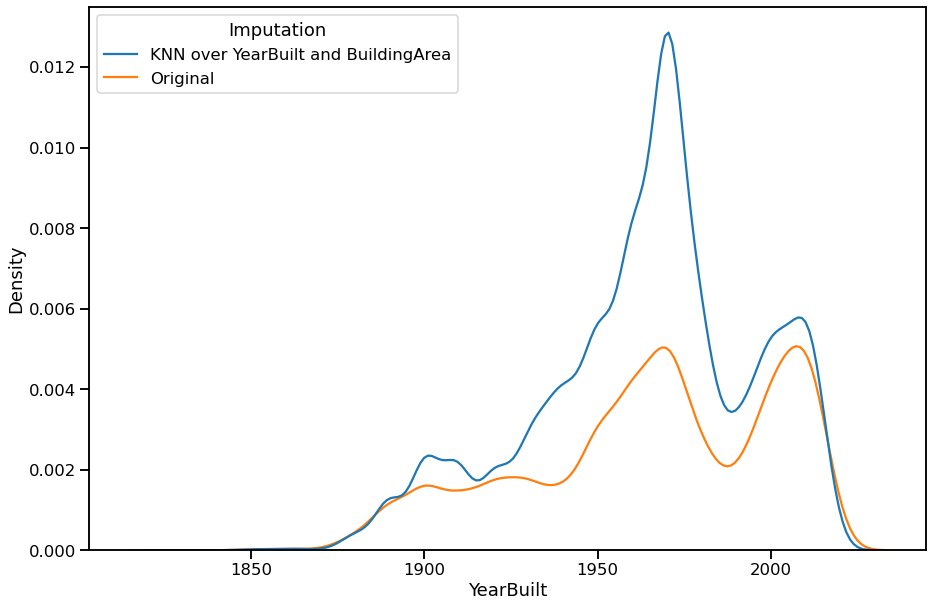

In [49]:
mice_year_built = df_to_impute.YearBuilt.to_frame()
mice_year_built['Imputation'] = 'KNN over YearBuilt and BuildingArea'
melb_year_build = melb_cat_df.YearBuilt.dropna().to_frame()
melb_year_build['Imputation'] = 'Original'
data = pd.concat([mice_year_built, melb_year_build]).reset_index(drop=True)
fig = plt.figure(figsize=(15, 10))
g = sns.kdeplot(data=data, x='YearBuilt', hue='Imputation')

## Ejercicio 3: Reducción de dimensionalidad.

Utilizando la matriz obtenida en el ejercicio anterior:
1. Aplique `PCA` para obtener $n$ componentes principales de la matriz, donde `n = min(20, X.shape[0])`. ¿Es necesario estandarizar o escalar los datos?
2. Grafique la varianza capturada por los primeros $n$ componentes principales, para cada $n$.
3. En base al gráfico, seleccione las primeras $m$ columnas de la matriz transformada para agregar como nuevas características al conjunto de datos.

## Ejercicio 4: Composición del resultado

Transformar nuevamente el conjunto de datos procesado en un `pandas.DataFrame` y guardarlo en un archivo.

Para eso, será necesario recordar el nombre original de cada columna de la matriz, en el orden correcto. Tener en cuenta:
1. El método `OneHotEncoder.get_feature_names` o el atributo `OneHotEncoder.categories_` permiten obtener una lista con los valores de la categoría que le corresponde a cada índice de la matriz.
2. Ninguno de los métodos aplicados intercambia de lugar las columnas o las filas de la matriz.

In [ ]:
## Small example
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder

## If we process our data with the following steps:
categorical_cols = ['Type', 'Regionname']
numerical_cols = ['Rooms', 'Distance']
new_columns = []

# Step 1: encode categorical columns
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
X_cat = encoder.fit_transform(melb_df[categorical_cols])
for col, col_values in zip(categorical_cols, encoder.categories_):
  for col_value in col_values:
    new_columns.append('{}={}'.format(col, col_value))
print("Matrix has shape {}, with columns: {}".format(X_cat.shape, new_columns))

# Step 2: Append the numerical columns
X = numpy.hstack([X_cat, melb_df[numerical_cols].values])
new_columns.extend(numerical_cols)
print("Matrix has shape {}, with columns: {}".format(X_cat.shape, new_columns))

# Step 3: Append some new features, like PCA
pca = PCA(n_components=2)
pca_dummy_features = pca.fit_transform(X)
X_pca = numpy.hstack([X, pca_dummy_features])
new_columns.extend(['pca1', 'pca2'])

## Re-build dataframe
processed_melb_df = pandas.DataFrame(data=X_pca, columns=new_columns)
processed_melb_df.head()

Matrix has shape (13580, 11), with columns: ['Type=h', 'Type=t', 'Type=u', 'Regionname=Eastern Metropolitan', 'Regionname=Eastern Victoria', 'Regionname=Northern Metropolitan', 'Regionname=Northern Victoria', 'Regionname=South-Eastern Metropolitan', 'Regionname=Southern Metropolitan', 'Regionname=Western Metropolitan', 'Regionname=Western Victoria']
Matrix has shape (13580, 11), with columns: ['Type=h', 'Type=t', 'Type=u', 'Regionname=Eastern Metropolitan', 'Regionname=Eastern Victoria', 'Regionname=Northern Metropolitan', 'Regionname=Northern Victoria', 'Regionname=South-Eastern Metropolitan', 'Regionname=Southern Metropolitan', 'Regionname=Western Metropolitan', 'Regionname=Western Victoria', 'Rooms', 'Distance']


,Type=h,Type=t,Type=u,Regionname=Eastern Metropolitan,Regionname=Eastern Victoria,Regionname=Northern Metropolitan,Regionname=Northern Victoria,Regionname=South-Eastern Metropolitan,Regionname=Southern Metropolitan,Regionname=Western Metropolitan,Regionname=Western Victoria,Rooms,Distance,pca1,pca2
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,2.5,-7.669418,-0.292703
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,2.5,-7.669418,-0.292703
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,2.5,-7.620201,0.619633
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,2.5,-7.620201,0.619633
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,2.5,-7.570984,1.531969


## Ejercicio 5: Documentación

En un documento `.pdf` o `.md` realizar un reporte de las operaciones que realizaron para obtener el conjunto de datos final. Se debe incluir:
  1. Criterios de exclusión (o inclusión) de filas
  2. Interpretación de las columnas presentes
  2. Todas las transofrmaciones realizadas

Este documento es de uso técnico exclusivamente, y su objetivo es permitir que otres desarrolladores puedan reproducir los mismos pasos y obtener el mismo resultado. Debe ser detallado pero consiso. Por ejemplo:

```
  ## Criterios de exclusión de ejemplos
  1. Se eliminan ejemplos donde el año de construcción es previo a 1900

  ## Características seleccionadas
  ### Características categóricas
  1. Type: tipo de propiedad. 3 valores posibles
  2. ...
  Todas las características categóricas fueron codificadas con un
  método OneHotEncoding utilizando como máximo sus 30 valores más 
  frecuentes.
  
  ### Características numéricas
  1. Rooms: Cantidad de habitaciones
  2. Distance: Distancia al centro de la ciudad.
  3. airbnb_mean_price: Se agrega el precio promedio diario de 
     publicaciones de la plataforma AirBnB en el mismo código 
     postal. [Link al repositorio con datos externos].

  ### Transformaciones:
  1. Todas las características numéricas fueron estandarizadas.
  2. La columna `Suburb` fue imputada utilizando el método ...
  3. Las columnas `YearBuilt` y ... fueron imputadas utilizando el 
     algoritmo ...
  4. ...

  ### Datos aumentados
  1. Se agregan las 5 primeras columnas obtenidas a través del
     método de PCA, aplicado sobre el conjunto de datos
     totalmente procesado.
```
